In [1]:
%load_ext autoreload
%autoreload 2


In [7]:
import os
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
import pickle

# from matplotlib import font_manager, rcParams
# custom_rc = {
#     'font.family': 'Arial',  # Set the desired font for this plot
# }

# mpl.rcParams['svg.fonttype'] = 'none'
# mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "dkd_Wilson"
file_name = "dkd_Wilson"
file_suffix = time.strftime('%b%d-%H%M')
seed = 0

save_dir = Path(f"../save/{proj_name}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)

ccd.ul.set_seed(seed)

In [4]:
# load the adata
# adata =  sc.read_h5ad(data_dir / f"{file_name}_final.h5ad")
adata =  sc.read_h5ad(data_dir / f"{file_name}_final_extend.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 39176 × 2000
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rpl', 'percent.rps', 'doublet_id', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches

In [ ]:
# # print the shape of the adata.obsm
# adata.obsm['X_harmony'].shape, adata.obsm['X_liger'].shape, adata.obsm['X_scanorama'].shape, adata.obsm['X_unintegrated'].shape, adata.obsm['X_scvi'].shape, \
# adata.obsm['X_concord_knn'].shape, adata.obsm['X_concord_hcl'].shape, adata.obsm['X_contrastive'].shape,

In [5]:
method_list = ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_knn', 'concord_hcl', 'contrastive']

batch_key = 'donor_id'
state_key = 'cell_type'

Embeddings: 100%|██████████| 8/8 [04:27<00:00, 33.42s/it]


Detected task: classification
Detected task: classification
[KNN] detected task: classification
[KNN] detected task: classification


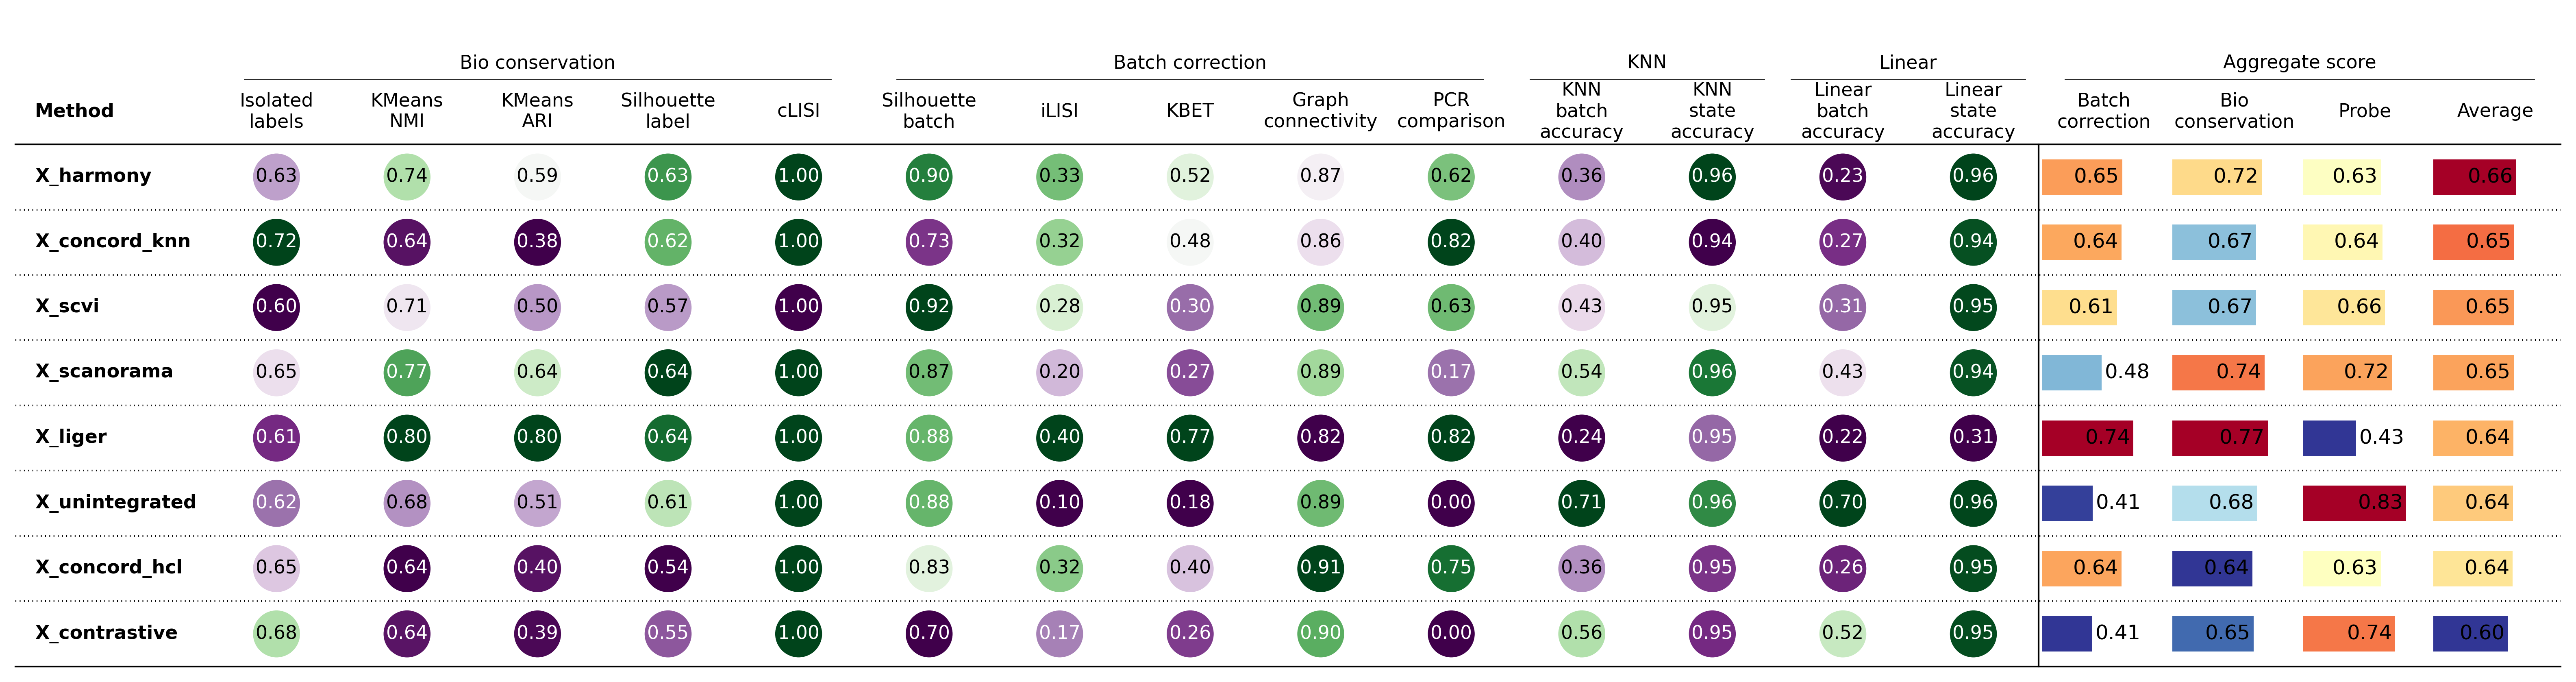

Bio conservation                                         \
                Isolated labels KMeans NMI KMeans ARI Silhouette label   
X_harmony              0.634404    0.74487   0.593591         0.627769   
X_concord_knn          0.724681   0.644062   0.383222         0.621311   
X_scvi                 0.597635   0.708927   0.498553         0.566305   
X_scanorama             0.65241     0.7674   0.642818         0.644638   
X_liger                0.610067   0.796534   0.799208         0.636466   
X_unintegrated         0.623766   0.678835   0.509242         0.606787   
X_concord_hcl          0.645187   0.636765   0.402574         0.535713   
X_contrastive          0.683711   0.644461   0.391586         0.553851   

                         Batch correction                      \
                   cLISI Silhouette batch     iLISI      KBET   
X_harmony            1.0         0.898868  0.329017  0.518453   
X_concord_knn        1.0         0.727522  0.315423  0.479647   
X_scvi          0.999799         0.924385  0.279335  0.299539   
X_scanorama          1.0         0.872585  0.203004  0.270877   
X_liger              1.0         0.876164  0.398872  0.770673   
X_unintegrated       1.0         0.875958   0.10168  0.182684   
X_concord_hcl        1.0         0.828339  0.319963  0.395806   
X_contrastive        1.0         0.701681  0.170845  0.257506   

                                                             KNN  \
               Graph connectivity PCR comparison batch\naccuracy   
X_harmony                0.867058       0.620527        0.358091   
X_concord_knn            0.862781       0.820756        0.403012   
X_scvi                   0.893102       0.634109        0.434150   
X_scanorama              0.887398       0.168753        0.543262   
X_liger                  0.824249       0.821567        0.237494   
X_unintegrated           0.893349              0        0.709546   
X_concord_hcl            0.913832       0.752952        0.360771   
X_contrastive            0.895905              0        0.557427   

                                        Linear                  \
               state\naccuracy batch\naccuracy state\naccuracy   
X_harmony             0.963119        0.228334        0.958519   
X_concord_knn         0.944104        0.270070        0.942055   
X_scvi                0.954952        0.308488        0.951883   
X_scanorama           0.961205        0.427824        0.938609   
X_liger               0.947677        0.217996        0.309764   
X_unintegrated        0.960567        0.698532        0.955456   
X_concord_hcl         0.946274        0.258711        0.947543   
X_contrastive         0.946018        0.522527        0.948309   

                Aggregate score                                       
               Batch correction Bio conservation     Probe   Average  
X_harmony              0.646785         0.720127  0.627016  0.664642  
X_concord_knn          0.641226         0.674655  0.639810  0.651897  
X_scvi                 0.606094         0.674244  0.662368  0.647569  
X_scanorama            0.480524         0.741453  0.717725  0.646567  
X_liger                0.738305         0.768455  0.428233  0.644998  
X_unintegrated         0.410734         0.683726  0.831025  0.641828  
X_concord_hcl          0.642179         0.644048  0.628325  0.638184  
X_contrastive          0.405187         0.654722  0.743570   0.60116

In [8]:
combined_keys = [
        "X_unintegrated",
        "X_scanorama", "X_liger", "X_harmony",
        "X_scvi", 
        "X_concord_knn", "X_concord_hcl", "X_contrastive"
    ]
out = ccd.bm.run_benchmark_pipeline(
    adata,
    embedding_keys=combined_keys,
    state_key=state_key,
    batch_key=batch_key,
    save_dir=save_dir / "benchmarks_out",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("scib", "probe"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
)
combined = out["combined"]
combined

In [10]:
# use scib-metrics to evaluate the embeddings
from benchmark_utils import run_scib_benchmark

embedding_keys = [f"X_{m}" for m in method_list]
bm = run_scib_benchmark(
    adata=adata,
    embedding_keys=embedding_keys, 
    batch_key=batch_key, # batch
    label_key=state_key, # label
    n_jobs=8
)

Embeddings: 100%|██████████| 8/8 [08:40<00:00, 65.07s/it] 


In [ ]:
# save the bm object in the save_dir
# import pickle
save_path = save_dir / f"{proj_name}_bm_{file_suffix}.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(bm, f)
print(f"Saved bm object to {save_path}")

Saved bm object to ../save/dkd_Wilson/dkd_Wilson_bm_Jun25-1738.pkl


In [ ]:
# load_path = Path("../save/dkd_Wilson/dkd_Wilson_bm_Jun25-1420_seed0.pkl")

# with open(load_path, 'rb') as f:
#     bm = pickle.load(f)

# print("✅ Loaded BM:", type(bm))


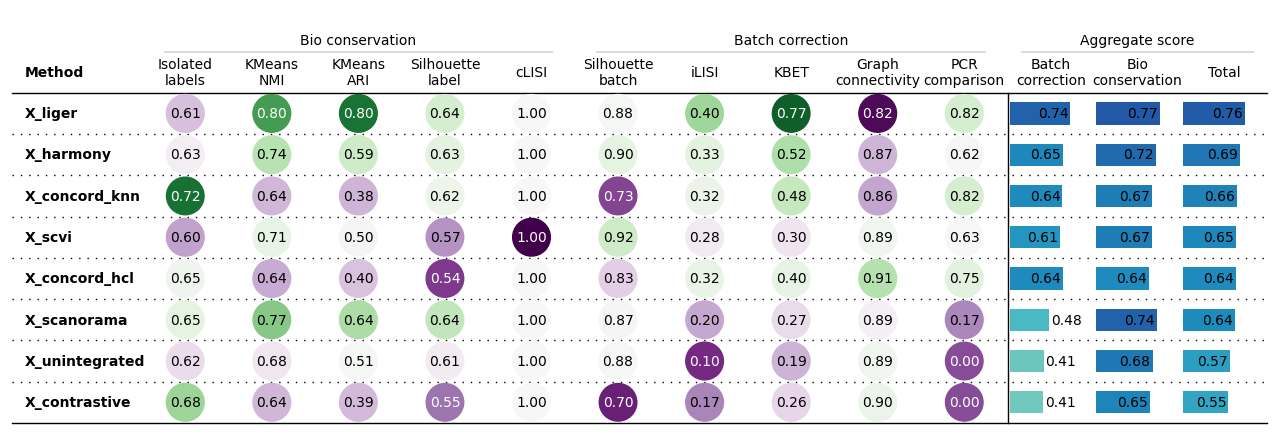

In [12]:
bm.plot_results_table(min_max_scale=False)

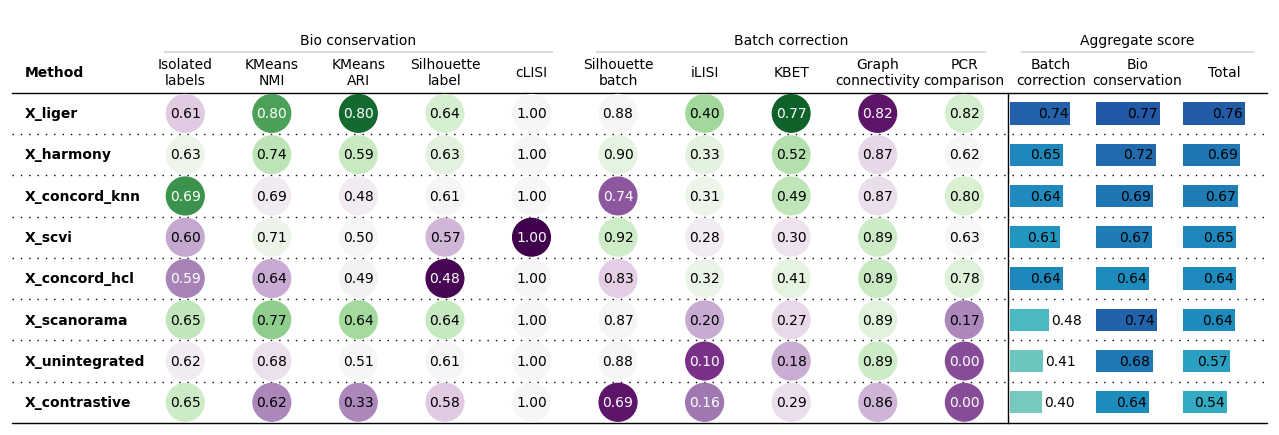

In [11]:
bm.plot_results_table(min_max_scale=False)

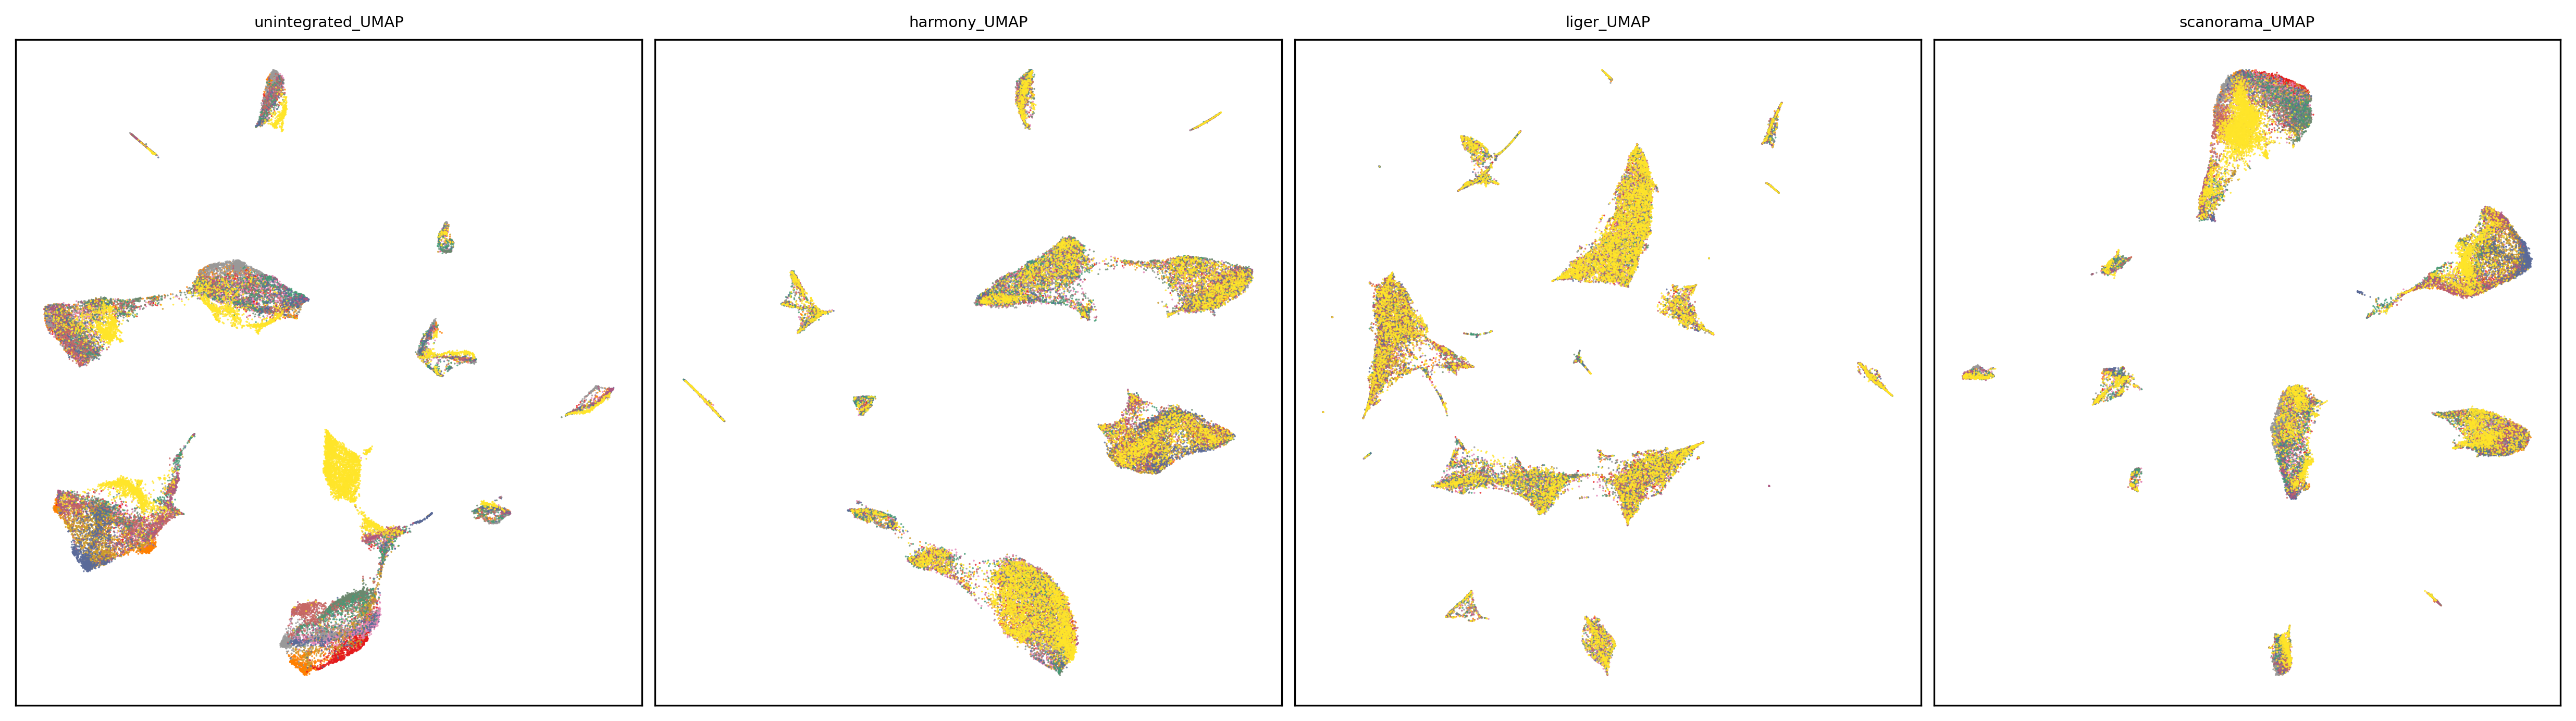

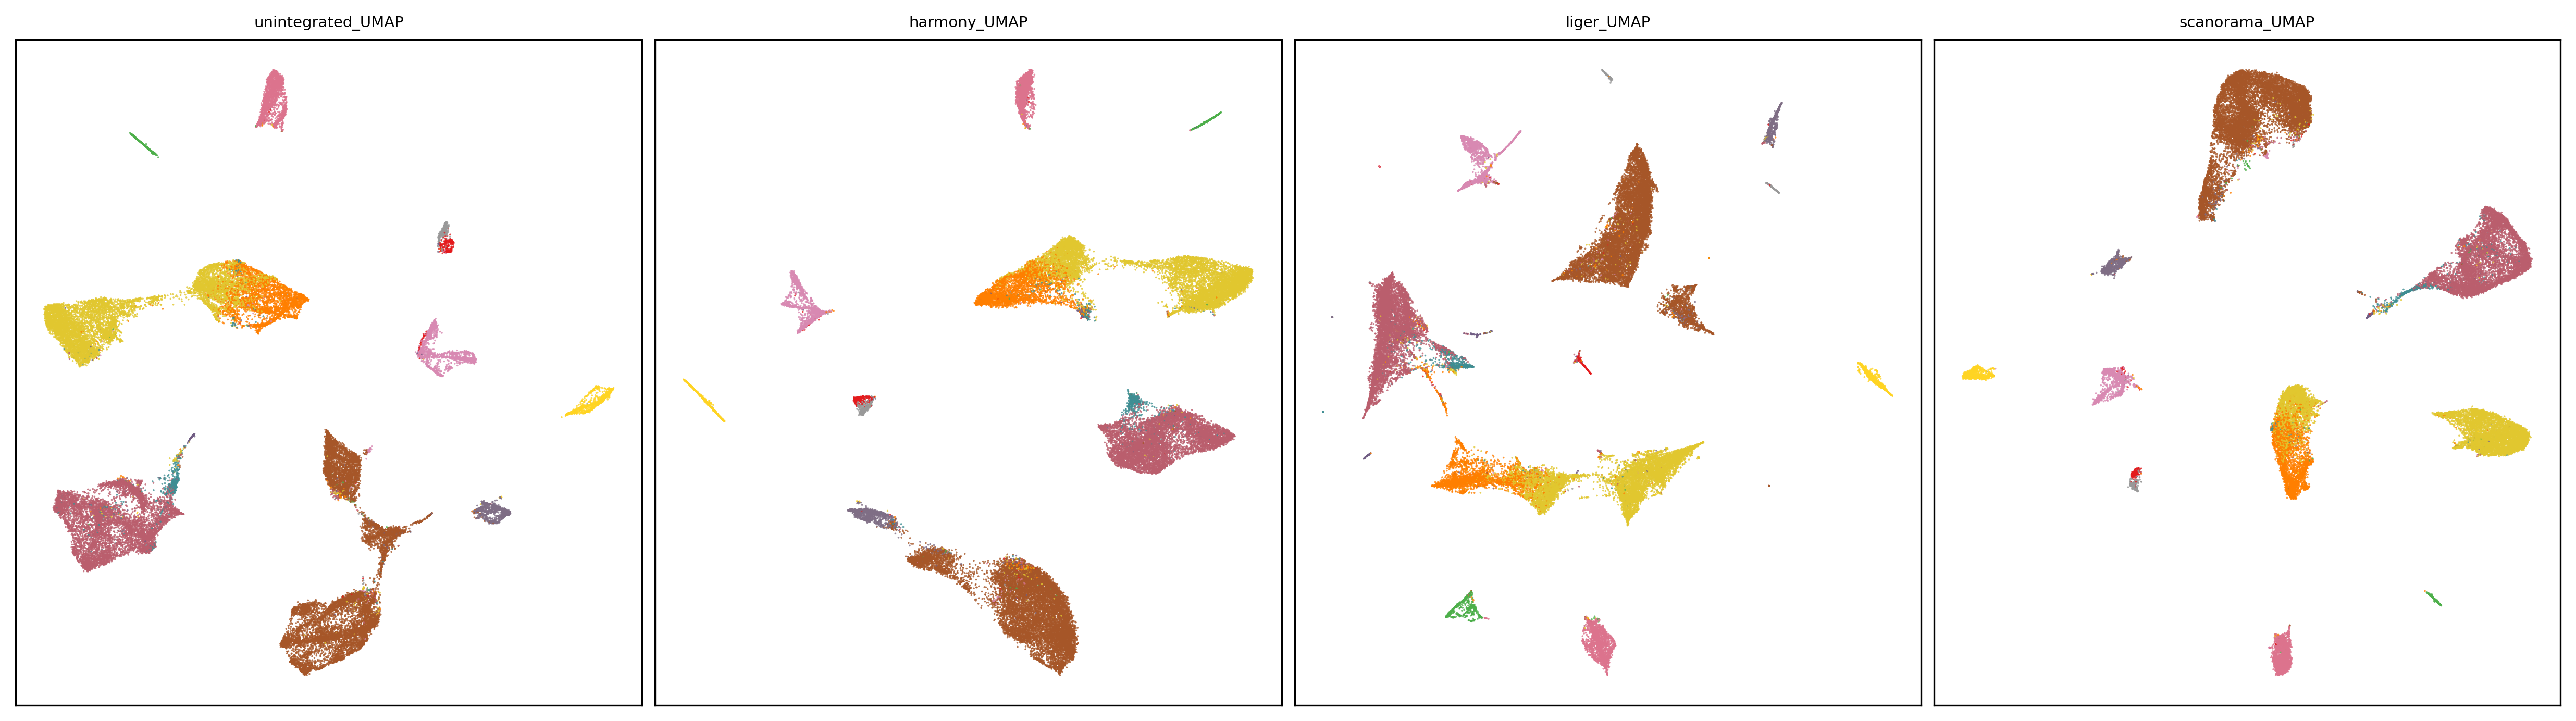

In [8]:
ccd.pl.plot_all_embeddings(
    adata=adata,
    combined_keys=['unintegrated_UMAP', 'harmony_UMAP', 'liger_UMAP', 'scanorama_UMAP'],
    color_bys = [batch_key, state_key],  # e.g., batch_key is 'dataset', state_key is 'cell_type'
    basis_types=['UMAP'],
    figsize=(45, 4.5),
    point_size=3,
    # save_dir=None
)

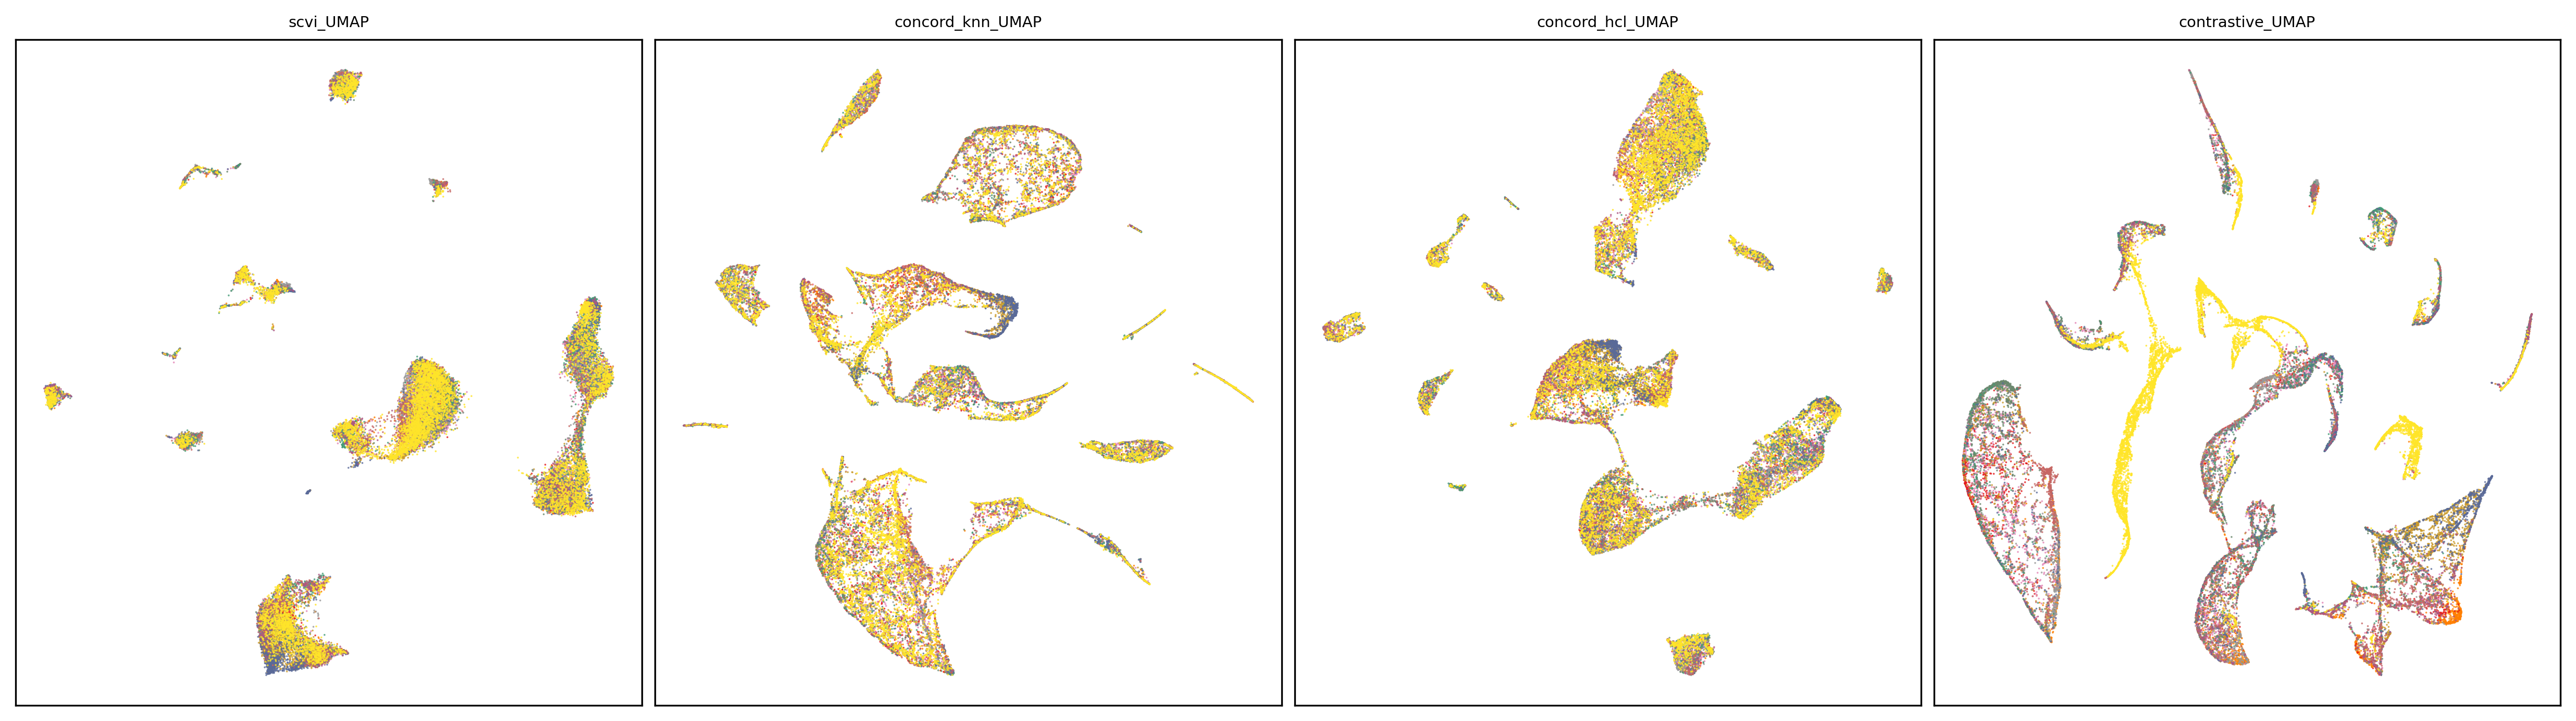

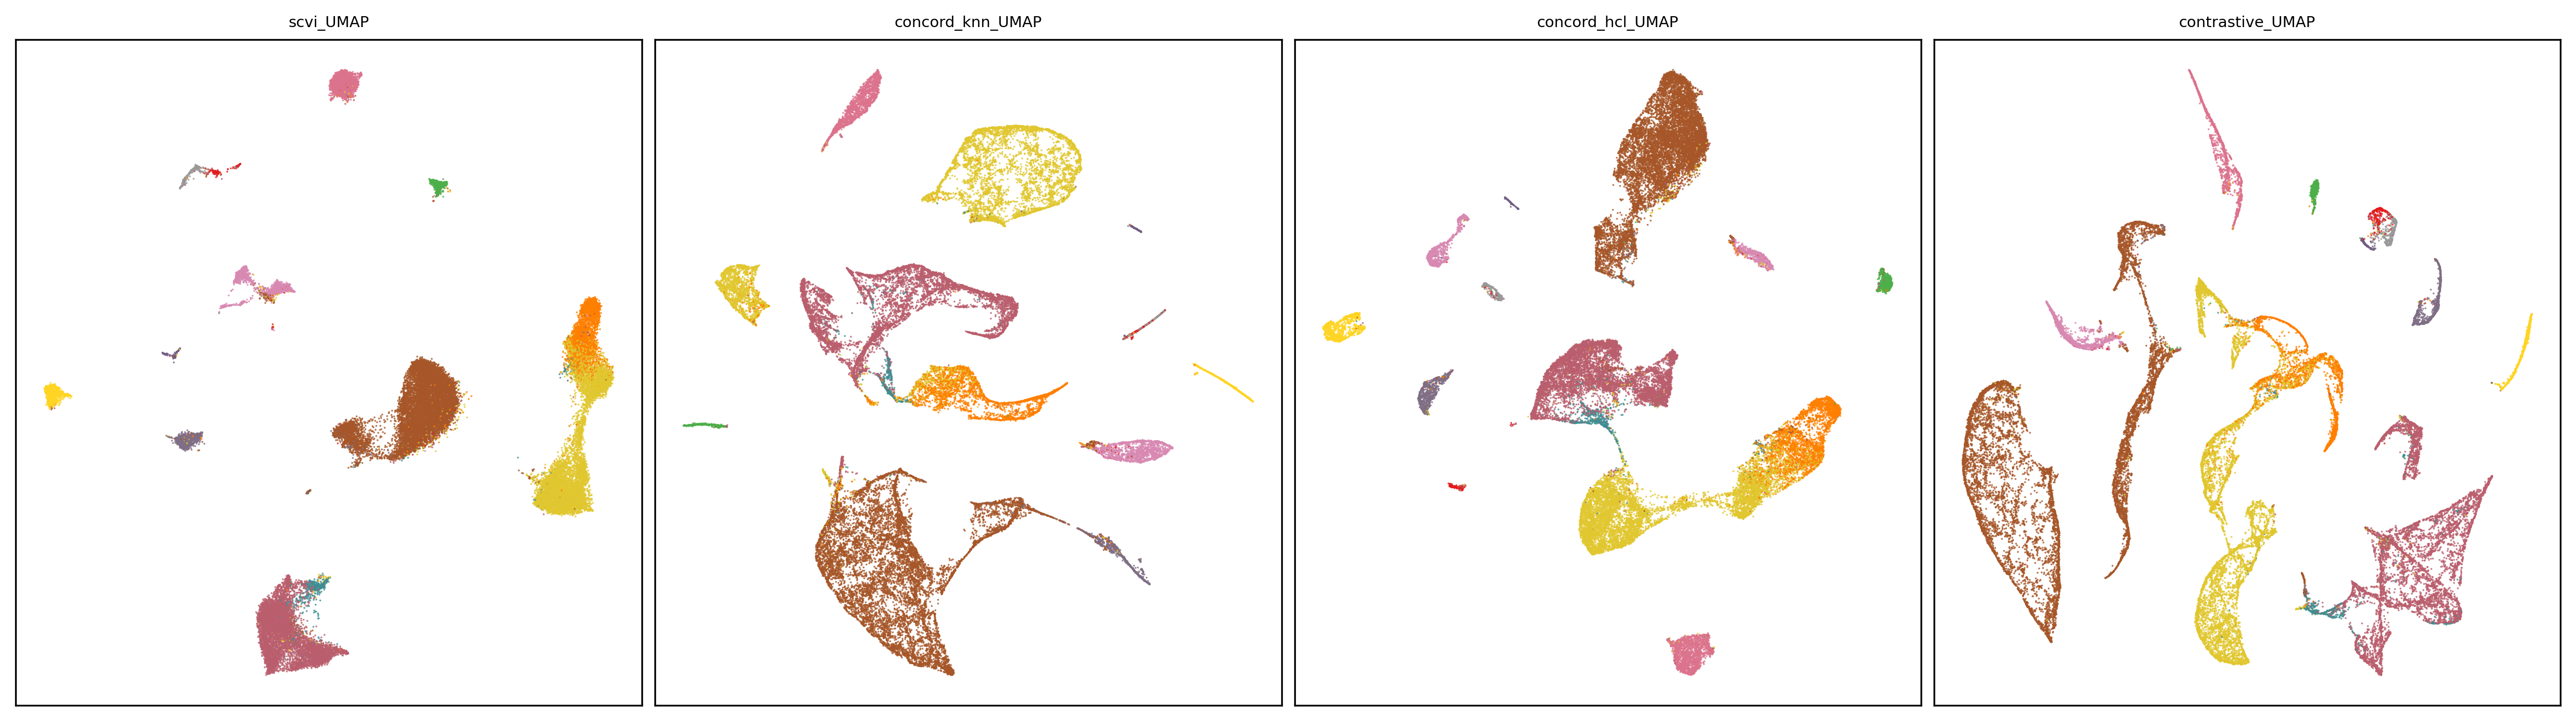

In [9]:
ccd.pl.plot_all_embeddings(
    adata=adata,
    combined_keys=['scvi_UMAP', 'concord_knn_UMAP', 'concord_hcl_UMAP', 'contrastive_UMAP'],
    color_bys = [batch_key, state_key],  # e.g., batch_key is 'dataset', state_key is 'cell_type'
    basis_types=['UMAP'],
    figsize=(45, 4.5),
    point_size=3,
    # save_dir=None
)

----

# viscello

in the viscello_env environment

In [1]:
import scanpy as sc
import concord as ccd
from pathlib import Path
import time
proj_name = "dkd_Wilson"
file_name = "dkd_Wilson"
data_dir = Path(f"../data/{file_name}")


In [2]:
# load the adata
adata =  sc.read_h5ad(data_dir / f"{file_name}_final_extend.h5ad")

In [3]:
file_suffix = time.strftime('%b%d-%H%M')

In [4]:
ccd.ul.anndata_to_viscello(adata, data_dir / f"cello_{proj_name}_{file_suffix}", project_name = proj_name, organism='hsa')
print(f"Saved viscello to {data_dir / f'cello_{proj_name}_{file_suffix}'}")

VisCello project created at ../data/dkd_Wilson/cello_dkd_Wilson_Jun25-1931
Saved viscello to ../data/dkd_Wilson/cello_dkd_Wilson_Jun25-1931
